# Setup

In [1]:
import pandas as pd
import numpy as np
import warnings

from io import StringIO
from calitp.tables import tbl
from datetime import date, datetime
from siuba import *
from plotnine import *

def friendly_date(x): 
    return datetime.strptime(x, "%Y-%m-%d").strftime("%b %d")

In [2]:
CALITP_ITP_ID = 98
#CALITP_ITP_ID=45
CALITP_URL_NUMBER = 0
DEBUG = False

START_DATE = "2021-05-01"
END_DATE = "2021-06-01"
DATE_TODAY=date.today()
START_MONTH_DAY = friendly_date(START_DATE)
END_MONTH_DAY = friendly_date(END_DATE)

WEEK_MARKERS = pd.date_range(START_DATE, END_DATE, freq="W").astype(str).tolist()
BIWEEKLY_MARKERS = pd.date_range(START_DATE, END_DATE, freq="2W").astype(str).tolist()

In [3]:
# Parameters
CALITP_ITP_ID = 34
CALITP_URL_NUMBER = 0
DEBUG = False
START_DATE = "2021-05-01"
END_DATE = "2021-06-01"


In [4]:
if not DEBUG:
    warnings.filterwarnings("ignore")

In [5]:
# Convenience functions ----

filter_start = filter(
    _.calitp_extracted_at <= START_DATE,
    _.calitp_deleted_at.fillna("2099-01-01") > START_DATE,
)

filter_end = filter(
    _.calitp_extracted_at <= END_DATE,
    _.calitp_deleted_at.fillna("2099-01-01") > END_DATE,
)

filter_itp = filter(
    _.calitp_itp_id == CALITP_ITP_ID, _.calitp_url_number == CALITP_URL_NUMBER
)

collect_to_dict = (
    collect()
    >> pipe(_.to_dict(orient="records")[0])
)


select_rm_calitp = select(
    -_.calitp_itp_id,
    -_.calitp_url_number,
    -_.calitp_hash,
    -_.calitp_extracted_at,
    -_.calitp_deleted_at,
)

def percent_format(labels):
    return ["{:.0f}%".format(v*100) for v in labels]

def query_id_changes(start_table, end_table, id_vars):
    """Calculate id variables that are removed, added, or unchanged between tables.
    
    It works by adding a special column to each table, performing a full join,
    then checking where the special column is null.
    """
    sym_id_vars = [_[k] for k in id_vars]

    is_in_start = start_table >> select(*id_vars) >> mutate(is_in_start=True)
    is_in_end = end_table >> select(*id_vars) >> mutate(is_in_end=True)

    baseline = start_table >> count(*id_vars) >> rename(n_baseline="n")
    tallies = (
        is_in_start
        >> full_join(_, is_in_end, id_vars)
        >> count(*sym_id_vars, _.is_in_start, _.is_in_end)
        >> mutate(
            status=case_when(
                _,
                {
                    _.is_in_end.isna(): "Removed",
                    _.is_in_start.isna(): "Added",
                    True: "Unchanged",
                },
            )
        )
        >> count(*sym_id_vars[:-1], _.status)
        >> group_by(*sym_id_vars[:-1])
        >> mutate(percent=_.n / _.n.sum())
    )

    return tallies

In [6]:
# Data ====
# 1. High level feed info ----
feed_info = (
    tbl.gtfs_schedule_type2.feed_info()
    >> filter_end
    >> filter_itp
    >> select_rm_calitp
    >> collect_to_dict
)

_n_routes = (
    tbl.gtfs_schedule_type2.routes() >> filter_end >> filter_itp >> count() >> collect()
)
_n_stops = (
    tbl.gtfs_schedule_type2.stops() >> filter_end >> filter_itp >> count() >> collect()
)

feed_info["n_routes"] = int(_n_routes.loc[0, "n"])
feed_info["n_stops"] = int(_n_stops.loc[0, "n"])

status = (
    tbl.views.gtfs_status_latest()
    >> filter(_.itp_id == CALITP_ITP_ID, _.url_number == CALITP_URL_NUMBER)
    >> select(-_.url_number, -_.status)
    >> select_rm_calitp
    >> collect_to_dict
)

# 2. Monthly metrics ----
# Service hours per day. Note that the queried table calculates service
# hours per service id, so we need to sum across service ids for the day
_cross_cal = (
    tbl.views.dim_date()
    >> filter(_.full_date.between(START_DATE, END_DATE))
    >> select(_.service_date == _.full_date)
)

tbl_daily_service_hours = (
    tbl.views.gtfs_schedule_service_daily_metrics()
    >> filter_itp
    >> filter(_.service_date.between(START_DATE, END_DATE))
    >> right_join(_, _cross_cal, ["service_date"])
    >> collect()
    >> group_by(_.service_date)
    >> summarize(
        ttl_service_hours=(_.last_arrival_ts.max() - _.first_departure_ts.min()) / 3600,
        ttl_service_hours2=_.ttl_service_hours.sum(),
    )
    >> mutate(
        ttl_service_hours=_.ttl_service_hours.astype(float).round(2),
        service_date=_.service_date.astype("datetime64[ns]"),
    )
)

# number of days where a feed did not have any trips in service
n_expired_days = (
    tbl_daily_service_hours
    >> filter(_.ttl_service_hours.isna())
    >> pipe(lambda d: {"n": d.shape[0]})
)

# 3. Stop and Route ID Changes ----

_tbl_stops_start = tbl.gtfs_schedule_type2.stops() >> filter_itp >> filter_start
_tbl_stops_end = tbl.gtfs_schedule_type2.stops() >> filter_itp >> filter_end
tbl_stops_changed = (
    query_id_changes(_tbl_stops_start, _tbl_stops_end, ["stop_id"]) >> collect()
)

_tbl_routes_start = tbl.gtfs_schedule_type2.routes() >> filter_itp >> filter_start
_tbl_routes_end = tbl.gtfs_schedule_type2.routes() >> filter_itp >> filter_end
tbl_routes_changed = (
    query_id_changes(_tbl_routes_start, _tbl_routes_end, ["route_id"]) >> collect()
)

In [7]:
# 4. Feed files being checked for ----

file_categories = pd.DataFrame(
    {
        "shapes.txt": "Visual display",
        "pathways.txt": "Navigation",
        "levels.txt": "Navigation",
        "fare_rules.txt": "Fares",
        "fare_leg_rules": "Fares",
        "feed_info.txt": "Technical contacts",
    }.items(),
    columns=["name", "category"],
)

importance = ["Visual display", "Navigation", "Fares", "Technical contacts"]

tbl_file_check = (
    tbl.gtfs_schedule_history.calitp_files_updates()
    >> filter_itp
    >> filter(_.calitp_extracted_at.isin(BIWEEKLY_MARKERS))
    >> select(_.name, _.calitp_extracted_at)
    >> collect()
    >> right_join(_, file_categories, ["name"])
    >> mutate(
        calitp_extracted_at=_.calitp_extracted_at.fillna("missing").astype(str),
        success="✅",
    )
    >> spread(_.calitp_extracted_at, _.success)
    >> select(-_.missing)
    >> arrange(_.category.apply(importance.index))
    >> select(_.category, _.contains(""))
    >> pipe(_.fillna(""))
)

tbl_validation_notices = (
    tbl.views.validation_notices()
    >> filter_itp
    >> filter(_.severity == "ERROR")
    >> count(_.code, _.severity)
    >> collect()
)

## Dump data

In [8]:
import json
import shutil

from pathlib import Path

out_dir = Path(f"output/{CALITP_ITP_ID}_{CALITP_URL_NUMBER}/data")
out_dir.mkdir(parents=True, exist_ok=True)

json.dump(feed_info, open(out_dir / "1_feed_info.json", "w"))
json.dump(status, open(out_dir / "1_status.json", "w"))

tbl_daily_service_hours.to_json(out_dir / "2_daily_service_hours.json", orient="records")
json.dump(n_expired_days, open(out_dir / "2_n_expired_days.json", "w"))

tbl_stops_changed.to_json(out_dir / "3_stops_changed.json", orient="records")
tbl_routes_changed.to_json(out_dir / "3_routes_changed.json", orient="records")
tbl_file_check.to_json(out_dir / "4_file_check.json", orient="records")
tbl_validation_notices.to_json(out_dir / "4_validation_notices.json", orient="records")


# Monthly GTFS Quality Report

In [9]:
from IPython.display import Markdown

Markdown(f"""
Transit provider name: {feed_info["feed_publisher_name"]}

Date generated: {DATE_TODAY}
""")


Transit provider name: Trillium Solutions, Inc.

Date generated: 2021-06-24


This is a monthly report, generated by the California Integrated Travel Project ([Cal-ITP](https://dot.ca.gov/cal-itp/cal-itp-gtfs)), summarizing issues discovered by [MobilityData](http://mobilitydata.io/)’s [GTFS Validator](https://github.com/MobilityData/gtfs-validator). This report is available for viewing by the general public to support continuous improvement of GTFS data and the experience of transit passengers. 

## Overview

In [10]:
Markdown(f"""
Feed location: {status["gtfs_schedule_url"]}

Metrics for the most recent published version of the feed:

* Date published: {feed_info["feed_version"]}
* Number of routes in any service: {feed_info["n_routes"]}
* Number of stops in service: {feed_info["n_stops"]}
""")


Feed location: http://data.trilliumtransit.com/gtfs/beaumont-ca-us/beaumont-ca-us.zip

Metrics for the most recent published version of the feed:

* Date published: UTC: 19-Apr-2021 23:12
* Number of routes in any service: 7
* Number of stops in service: 126


## Aggregated Metrics for May

In [11]:
# TODO: 

# Markdown(f"""
# Days when the active feed was expired: {n_expired_days["n"]}
# """)

Markdown(f"""
Days with no service hours: {n_expired_days["n"]}
""")



Days with no service hours: 6


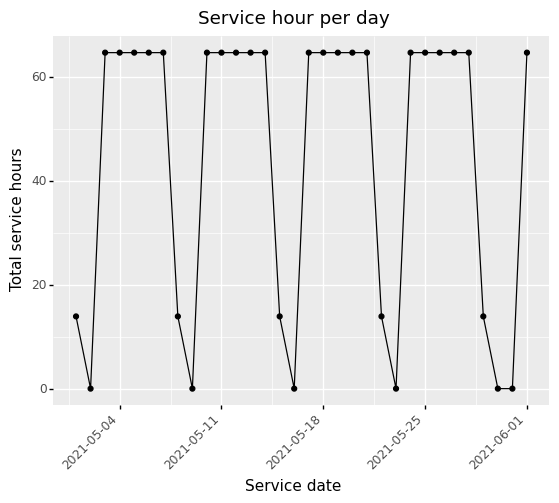

In [12]:
(
    tbl_daily_service_hours
    >> ggplot(aes("service_date", "ttl_service_hours2"))
    + geom_line()
    + geom_point()
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + scale_x_datetime(date_breaks="1 week")
    + expand_limits(y=0)
    + labs(y = "Total service hours", x = "Service date", title="Service hour per day")
).draw();

## Changes Since Previous Month

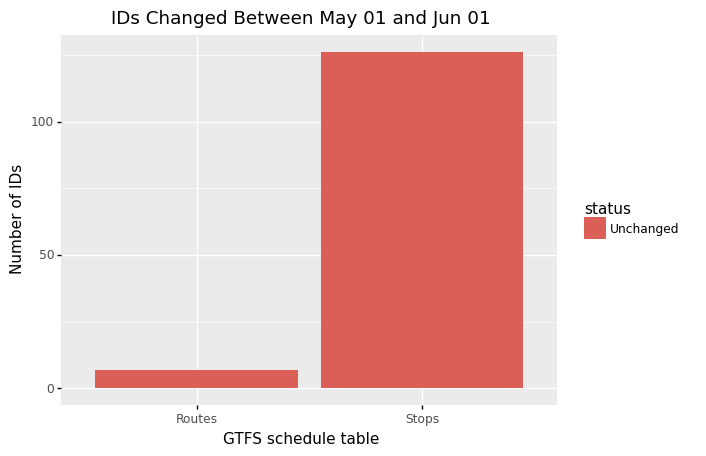

In [13]:
(
    pd.concat(
        [
            tbl_stops_changed >> mutate(kind="Stops"),
            tbl_routes_changed >> mutate(kind="Routes"),
        ]
    )
    >> ggplot(aes("kind", "n", fill="status"))
    + geom_col()
    + labs(
        x="GTFS schedule table",
        y="Number of IDs",
        title=f"IDs Changed Between {START_MONTH_DAY} and {END_MONTH_DAY}",
    )
).draw();

### (Alternative version using percentages)

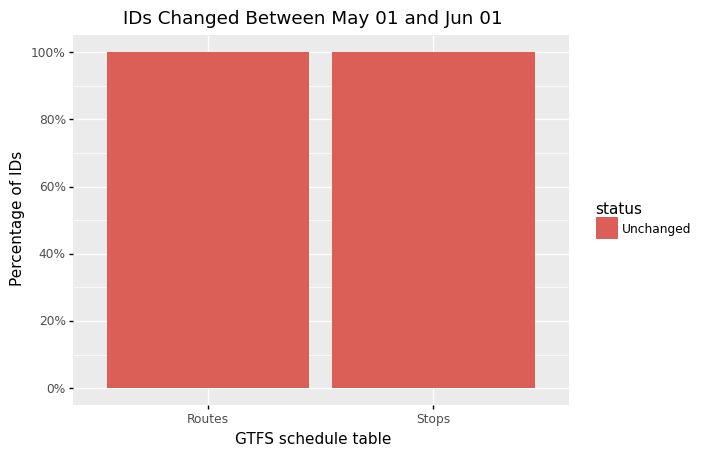

In [14]:
(
    pd.concat(
        [
            tbl_stops_changed >> mutate(kind="Stops"),
            tbl_routes_changed >> mutate(kind="Routes"),
        ]
    )
    >> ggplot(aes("kind", "percent", fill="status"))
    + geom_col()
    + labs(
        x="GTFS schedule table",
        y="Percentage of IDs",
        title=f"IDs Changed Between {START_MONTH_DAY} and {END_MONTH_DAY}",
    )
    + scale_y_continuous(labels=percent_format, breaks=np.arange(0, 1.2, 0.2))
).draw();

## Consistency with the [California GTFS Minimum Guidelines](https://dot.ca.gov/cal-itp/california-minimum-general-transit-feed-specification-gtfs-guidelines) for the feed downloaded


### Do the following files/fields exist?

In [15]:
tbl_file_check

,category,name,2021-05-02,2021-05-16,2021-05-30
5,Visual display,shapes.txt,✅,✅,✅
3,Navigation,levels.txt,,,
4,Navigation,pathways.txt,,,
0,Fares,fare_leg_rules,,,
1,Fares,fare_rules.txt,✅,✅,✅
2,Technical contacts,feed_info.txt,✅,✅,✅


### Validation Errors Observed

In [16]:
if tbl_validation_notices.shape[0] == 0:
    display(Markdown("No validation error observed in your feed."))
else:    
    display(tbl_validation_notices)

,code,severity,n
0,invalid_phone_number,ERROR,1


For more information about Cal-ITP, including the [Minimum GTFS Guidelines](https://dot.ca.gov/cal-itp/california-minimum-general-transit-feed-specification-gtfs-guidelines) and our [Transit Data Helpdesk](https://dot.ca.gov/programs/rail-and-mass-transportation/gtfs/helpdesk), contact [GTFSRT@dot.ca.gov](mailto:GTFSRT@dot.ca.gov).